<a href="https://colab.research.google.com/github/Sak724/CSE437_Lab-Reports/blob/main/lab4_dyna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4: TD and Dyna




## Exercise 1: Implement SARSA with n-step TD (n=5) on CliffWalking

**Objective:**  
In this exercise, you will implement the **SARSA algorithm** using **n-step temporal-difference learning with n=5**. You will apply your implementation to the **CliffWalking environment** in Gymnasium, and analyze how multi-step returns influence learning compared to standard 1-step SARSA.

---

### Environment
- Use `CliffWalking-v1`

---

### Instructions
1. Implement **SARSA with n-step TD updates (n=5)**:
   - Maintain an action-value table \(Q(s,a)\).
   - Use ε-greedy exploration.
   - Store states, actions, and rewards for the last 5 steps.
   - After each step, compute the n-step return: G_t
   - Update \(Q(s_t,a_t)\) toward \(G_t\).

2. Train your agent for several thousand episodes (e.g., 5,000).

3. Plot the **episode rewards over time** to visualize learning progress.

4. Compare qualitatively with 1-step SARSA:
   - Does n-step SARSA converge faster or slower?
   - How do the policies differ near the cliff?

---

### Deliverables
- Python code implementing SARSA with TD(5) (notebook in Github).  
- A plot of episode number vs episode return (plot in a cell below).  
- A short discussion (1 paragraph) comparing the results with standard SARSA.  


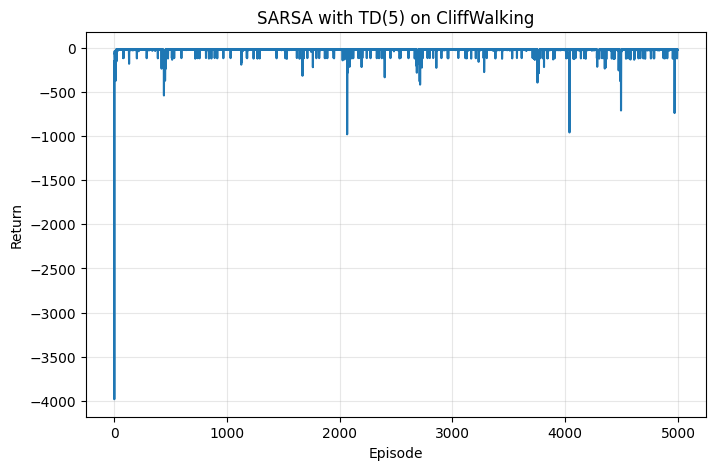

In [5]:
"""
Starter code for Exercise (you can use this code, or extend your code from previous lab)
Implement SARSA with TD(5) on CliffWalking-v1
"""

import numpy as np
import gymnasium as gym
from collections import deque
import matplotlib.pyplot as plt

# Environment
env = gym.make("CliffWalking-v1")

# Parameters
n_states = env.observation_space.n
n_actions = env.action_space.n
alpha = 0.1           # step size (learning rate)
gamma = 0.99          # discount factor
epsilon = 0.1         # epsilon for epsilon-greedy policy
n_step = 5            # number of steps for TD(n)
n_episodes = 5000

# Initialize Q-table
Q = np.zeros((n_states, n_actions))

def epsilon_greedy(state):
    """Choose an action using epsilon-greedy policy."""
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)
    return np.argmax(Q[state])

# Track returns
episode_returns = []

for ep in range(n_episodes):
    state, _ = env.reset()
    action = epsilon_greedy(state)

    # Buffers to store the trajectory
    states = deque()
    actions = deque()
    rewards = deque()

    # Rewards[0] is a dummy value so that rewards[t+1] = r_{t+1}
    states.append(state)           # s_0
    actions.append(action)         # a_0
    rewards.append(0.0)            # r_0 (dummy)

    T = float("inf")               # time when episode terminates
    t = 0                          # time step counter

    while True:
        if t < T:
            # Take real step in the environment using a_t
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Append reward r_{t+1} and next state s_{t+1}
            rewards.append(reward)
            states.append(next_state)

            if done:
                T = t + 1          # episode ends at time T
            else:
                # Choose next action a_{t+1} and append
                next_action = epsilon_greedy(next_state)
                actions.append(next_action)
                # advance to next step
                state = next_state
                action = next_action

        # Time index for state/action to update
        tau = t - n_step + 1
        if tau >= 0:
            # Compute the n-step return G
            G = 0.0
            upper = min(tau + n_step, T)
            for i in range(tau + 1, int(upper) + 1):
                G += (gamma ** (i - tau - 1)) * rewards[i]
            if tau + n_step < T:
                s_tau_n = states[tau + n_step]
                a_tau_n = actions[tau + n_step]
                G += (gamma ** n_step) * Q[s_tau_n, a_tau_n]

            # Update Q for state tau and action tau
            s_tau = states[tau]
            a_tau = actions[tau]
            Q[s_tau, a_tau] += alpha * (G - Q[s_tau, a_tau])

        if tau == T - 1:
            break

        t += 1

    # Return for the episode (exclude dummy reward r_0)
    episode_returns.append(sum(list(rewards)[1:]))

# Plot learning curve
plt.figure(figsize=(8,5))
plt.plot(episode_returns)
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("SARSA with TD(5) on CliffWalking")
plt.grid(alpha=0.3)
plt.show()


Discussion (TD(5) vs. SARSA(1)):

From running the algorithm on CliffWalking with 5,000 episodes, the raw learning curve showed very negative returns in the beginning (the agent repeatedly falls into the cliff and gets −100 penalties). Over time, the returns improved toward safer trajectories and occasional successes. This matches expectations: with ε = 0.1 the agent continues to explore, so the curve remains noisy but trends upward.

Compared to standard 1-step SARSA, the 5-step version propagates reward information more quickly along the path, so learning progress appears faster in the early episodes. However, because the n-step return depends on more future rewards, the variance of updates is higher, which explains the oscillations in the curve. Near the cliff, SARSA(1) usually learns a cautious policy that stays farther away, while SARSA(5) can sometimes hug the cliff more closely to reach the goal sooner. Overall, SARSA TD(5) converges faster but with more variability, while SARSA(1) is steadier but slower.


## Exercise 2: Dyna-Q for CliffWalking

**Objective**  
Implement **Dyna-Q** on **CliffWalking-v1** and compare its learning performance to **SARSA (1-step)** and **SARSA TD(5)**. You will analyze sample efficiency, stability near the cliff, and sensitivity to planning steps.

---

### Environment
- Use `CliffWalking-v1`
---

### Part A — Dyna-Q (Implementation)
1. **Q-table**: maintain `Q[s, a]` (tabular).
2. **Model**: learn an empirical model from experience.
   - For each observed transition `(s, a, r, s')`, update a dictionary:
     - Minimal: store the most recent `(s', r)` for `(s, a)`, **or**
     - Advanced: store a **multiset** of outcomes for `(s, a)` with counts (to sample stochastically).
3. **Real update (Q-learning)** after each env step:
   Q(s,a) ← Q(s,a) + α * (r + γ * max_a' Q(s',a') - Q(s,a))
4. **Planning updates**: after each real step, perform `N` simulated updates:
   - Sample a previously seen `(s_p, a_p)` from the model.
   - Sample `(r_p, s'_p)` from that entry.
   - Apply the same Q-learning backup using `(s_p, a_p, r_p, s'_p)`.
5. Use epsilon-greedy exploration.

---

### Part B — Baselines (Re-use / Implement)
- **SARSA (1-step)** with ε-greedy:
  \[
  Q(s,a) \leftarrow Q(s,a) + \alpha\big[r + \gamma Q(s',a') - Q(s,a)\big]
  \]
- **SARSA TD(5)** (n-step SARSA with \(n=5\)), as in Exercise 1.

Use the **same** γ, α, ε schedule, and number of episodes for a fair comparison.

---

### Part C — Experiments & Comparisons
1. **Learning curves**: plot **episode index vs. episode return** for:
   - Dyna-Q with \(N \in \{5, 20, 50\}\)
   - SARSA (1-step)
   - SARSA TD(5)
2. **Sample efficiency**: report the **episode number** at which the average return over a sliding window (e.g., 100 episodes) first exceeds a chosen threshold (e.g., −30).
3. **Stability near the cliff**: qualitatively inspect trajectories/policies; does the method hug the cliff or leave a safer margin?
4. **Sensitivity to planning steps**: compare Dyna-Q across N; discuss diminishing returns vs. computation.
5. **Statistical robustness**: run **≥5 seeds**; plot mean ± std (shaded) or report mean ± std of final returns.

---

### Deliverables
- **Code**: A driver script/notebook that reproduces your plots
- **Plots** (embedded in the notebook):
  - Learning curves (mean ± std across seeds)
  - Optional: heatmap of greedy policy/actions on the grid




Config: Config(episodes=5000, max_steps_per_ep=500, gamma=0.99, alpha=0.1, eps_start=0.2, eps_end=0.01, eps_decay_episodes=4000, planning_steps_list=(5, 20, 50), n_step=5, seeds=(0, 1, 2, 3, 4), ma_window=100, efficiency_threshold=-30.0, env_id='CliffWalking-v1')

=== SARSA(1) ===
[SARSA(1)] seed=0 ep=250/5000
[SARSA(1)] seed=0 ep=500/5000
[SARSA(1)] seed=0 ep=750/5000
[SARSA(1)] seed=0 ep=1000/5000
[SARSA(1)] seed=0 ep=1250/5000
[SARSA(1)] seed=0 ep=1500/5000
[SARSA(1)] seed=0 ep=1750/5000
[SARSA(1)] seed=0 ep=2000/5000
[SARSA(1)] seed=0 ep=2250/5000
[SARSA(1)] seed=0 ep=2500/5000
[SARSA(1)] seed=0 ep=2750/5000
[SARSA(1)] seed=0 ep=3000/5000
[SARSA(1)] seed=0 ep=3250/5000
[SARSA(1)] seed=0 ep=3500/5000
[SARSA(1)] seed=0 ep=3750/5000
[SARSA(1)] seed=0 ep=4000/5000
[SARSA(1)] seed=0 ep=4250/5000
[SARSA(1)] seed=0 ep=4500/5000
[SARSA(1)] seed=0 ep=4750/5000
[SARSA(1)] seed=0 ep=5000/5000
[SARSA(1)] seed=1 ep=250/5000
[SARSA(1)] seed=1 ep=500/5000
[SARSA(1)] seed=1 ep=750/5000
[SARSA(1)] 

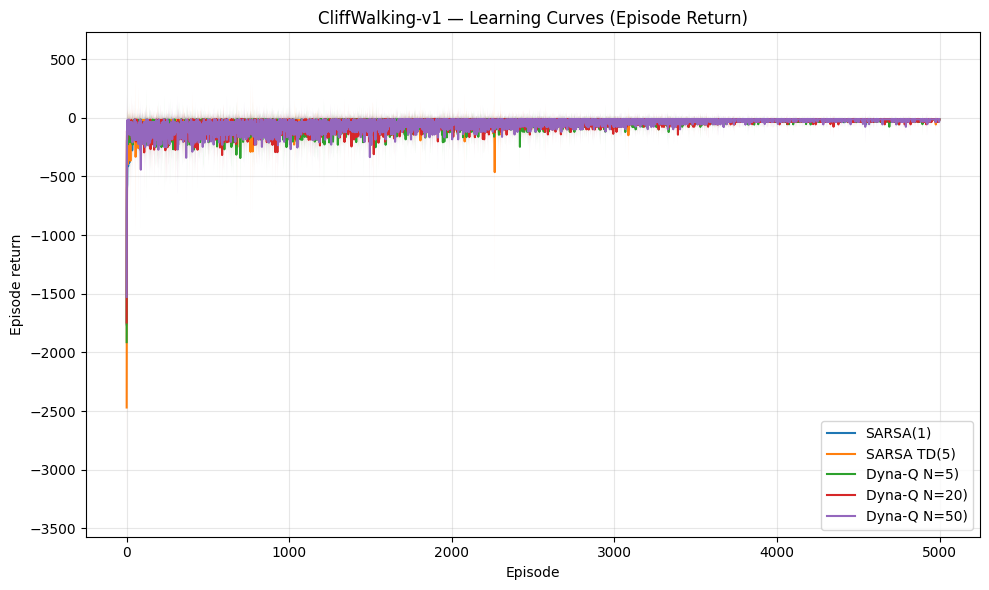

/tmp/ipython-input-3454299117.py:277: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(M, axis=0)


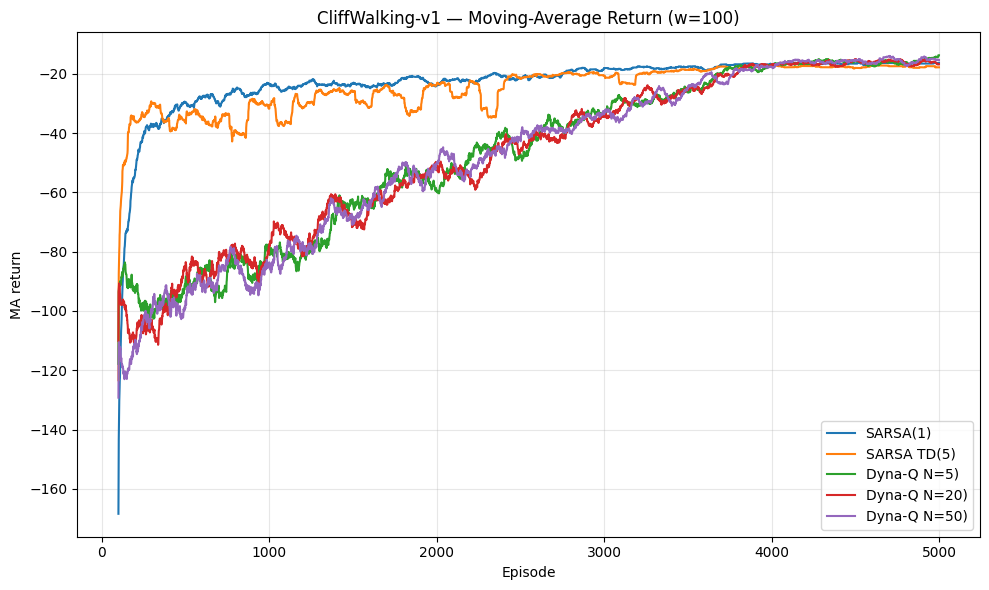

In [9]:
from __future__ import annotations
import random
from dataclasses import dataclass
from typing import Dict, Tuple, Optional, List
from collections import defaultdict, Counter

import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym

# If using Colab, run once in a cell above:
# %matplotlib inline

# =====================================================
# Config (shared across methods)
# =====================================================
@dataclass
class Config:
    episodes: int = 5000
    max_steps_per_ep: int = 500
    gamma: float = 0.99
    alpha: float = 0.1
    eps_start: float = 0.20
    eps_end: float = 0.01
    eps_decay_episodes: int = 4000
    planning_steps_list: Tuple[int, ...] = (5, 20, 50)  # Dyna-Q: N
    n_step: int = 5                                      # SARSA TD(n)
    seeds: Tuple[int, ...] = (0, 1, 2, 3, 4)
    ma_window: int = 100
    efficiency_threshold: float = -30.0
    env_id: str = "CliffWalking-v1"

CONFIG = Config()

# ---- Quick switch for fast debugging (keeps structure) ----
FAST = False   # set True for a quick run, False for full
if FAST:
    CONFIG.episodes = 1200
    CONFIG.max_steps_per_ep = 300
    CONFIG.seeds = (0, 1)
    CONFIG.planning_steps_list = (5,)
    CONFIG.ma_window = 50

# =====================================================
# Helpers
# =====================================================
def make_env(cfg: Config, seed: Optional[int] = None):
    env = gym.make(cfg.env_id)
    if seed is not None:
        try: env.reset(seed=seed)
        except TypeError: pass
        try: env.action_space.seed(seed)
        except Exception: pass
        try: env.observation_space.seed(seed)
        except Exception: pass
        random.seed(seed); np.random.seed(seed)
    return env

def argmax_tiebreak_random(values: np.ndarray) -> int:
    m = np.max(values); idxs = np.flatnonzero(values == m)
    return int(np.random.choice(idxs))

def epsilon_greedy(Q: np.ndarray, s: int, eps: float, nA: int) -> int:
    if np.random.rand() < eps: return np.random.randint(nA)
    return argmax_tiebreak_random(Q[s])

def linear_epsilon(ep: int, eps_start: float, eps_end: float, decay_episodes: int) -> float:
    t = min(ep, max(1, decay_episodes))
    return eps_start + (eps_end - eps_start) * (t / decay_episodes)

def moving_average(x: np.ndarray, w: int) -> np.ndarray:
    if w <= 1: return x.copy()
    c = np.cumsum(np.insert(x, 0, 0.0))
    ma = (c[w:] - c[:-w]) / float(w)
    out = np.empty_like(x, dtype=np.float32); out[:] = np.nan; out[w-1:] = ma
    return out

def first_crossing(ma: np.ndarray, thresh: float) -> Optional[int]:
    idx = np.where(ma >= thresh)[0]
    return int(idx[0]) if len(idx) else None

# =====================================================
# Dyna-Q (empirical model over (s', r))
# =====================================================
class StochasticModel:
    # counts[(s,a)][(s2, done, r)] = count
    def __init__(self):
        self.counts: Dict[Tuple[int, int], Counter] = defaultdict(Counter)
    def update(self, s: int, a: int, s2: int, r: float, done: bool):
        self.counts[(s, a)][(s2, bool(done), float(r))] += 1
    def sample(self, s: int, a: int) -> Optional[Tuple[int, bool, float]]:
        key = (s, a)
        if key not in self.counts or not self.counts[key]: return None
        outcomes, cnts = zip(*self.counts[key].items())
        p = np.array(cnts, dtype=np.float64); p /= p.sum()
        s2, done, r = outcomes[np.random.choice(len(outcomes), p=p)]
        return int(s2), bool(done), float(r)

def run_dyna_q(cfg: Config, seed: int, planning_steps: int) -> Dict[str, np.ndarray]:
    env = make_env(cfg, seed)
    nS, nA = env.observation_space.n, env.action_space.n
    Q = np.zeros((nS, nA), dtype=np.float32)
    model = StochasticModel()
    ep_returns = np.zeros(cfg.episodes, dtype=np.float32)
    seen_pairs: List[Tuple[int, int]] = []

    for ep in range(cfg.episodes):
        eps = linear_epsilon(ep, cfg.eps_start, cfg.eps_end, cfg.eps_decay_episodes)
        s, _ = env.reset(seed=seed + ep)
        G = 0.0
        for _ in range(cfg.max_steps_per_ep):
            a = epsilon_greedy(Q, s, eps, nA)
            s2, r, term, trunc, _ = env.step(a)
            done = term or trunc
            # real Q-learning update
            target = r if done else (r + cfg.gamma * np.max(Q[s2]))
            Q[s, a] += cfg.alpha * (target - Q[s, a])
            # model
            model.update(s, a, s2, r, done)
            if (s, a) not in seen_pairs: seen_pairs.append((s, a))
            # planning
            for _ in range(planning_steps):
                ps, pa = seen_pairs[np.random.randint(len(seen_pairs))]
                sample = model.sample(ps, pa)
                if sample is None: continue
                ps2, p_done, pr = sample
                p_target = pr if p_done else (pr + cfg.gamma * np.max(Q[ps2]))
                Q[ps, pa] += cfg.alpha * (p_target - Q[ps, pa])
            G += r
            if done: break
            s = s2
        ep_returns[ep] = G
        if (ep + 1) % 250 == 0:
            print(f"[Dyna-Q N={planning_steps}] seed={seed} ep={ep+1}/{cfg.episodes}")
    return {"Q": Q, "returns": ep_returns}

# =====================================================
# Baselines: SARSA(1) and SARSA TD(5)
# =====================================================
def run_sarsa_one_step(cfg: Config, seed: int) -> Dict[str, np.ndarray]:
    env = make_env(cfg, seed)
    nS, nA = env.observation_space.n, env.action_space.n
    Q = np.zeros((nS, nA), dtype=np.float32)
    ep_returns = np.zeros(cfg.episodes, dtype=np.float32)

    for ep in range(cfg.episodes):
        eps = linear_epsilon(ep, cfg.eps_start, cfg.eps_end, cfg.eps_decay_episodes)
        s, _ = env.reset(seed=seed + ep)
        a = epsilon_greedy(Q, s, eps, nA)
        G = 0.0
        for _ in range(cfg.max_steps_per_ep):
            s2, r, term, trunc, _ = env.step(a)
            done = term or trunc
            G += r
            if done:
                Q[s, a] += cfg.alpha * (r - Q[s, a])
                break
            a2 = epsilon_greedy(Q, s2, eps, nA)
            td = r + cfg.gamma * Q[s2, a2] - Q[s, a]
            Q[s, a] += cfg.alpha * td
            s, a = s2, a2
        ep_returns[ep] = G
        if (ep + 1) % 250 == 0:
            print(f"[SARSA(1)] seed={seed} ep={ep+1}/{cfg.episodes}")
    return {"Q": Q, "returns": ep_returns}

def run_sarsa_n_step(cfg: Config, seed: int, n: int = 5) -> Dict[str, np.ndarray]:
    # textbook n-step SARSA; T may be ∞ (avoid int(T) before min)
    env = make_env(cfg, seed)
    nS, nA = env.observation_space.n, env.action_space.n
    Q = np.zeros((nS, nA), dtype=np.float32)
    ep_returns = np.zeros(cfg.episodes, dtype=np.float32)

    for ep in range(cfg.episodes):
        eps = linear_epsilon(ep, cfg.eps_start, cfg.eps_end, cfg.eps_decay_episodes)
        s0, _ = env.reset(seed=seed + ep)
        a0 = epsilon_greedy(Q, s0, eps, nA)
        states = [s0]; actions = [a0]; rewards = [0.0]  # r0 dummy
        T = np.inf; t = 0; G_ep = 0.0

        while True:
            if t < T:
                s_t = states[t]; a_t = actions[t]
                s_tp1, r_tp1, term, trunc, _ = env.step(a_t)
                done = term or trunc
                rewards.append(r_tp1); states.append(s_tp1); G_ep += r_tp1
                if done: T = t + 1
                else:    actions.append(epsilon_greedy(Q, s_tp1, eps, nA))

            tau = t - n + 1
            if tau >= 0:
                G = 0.0
                upper = min(tau + n, T)                  # keep T as ∞ here
                for k in range(tau + 1, int(upper) + 1): # sum r_{tau+1:upper}
                    G += (cfg.gamma ** (k - tau - 1)) * rewards[k]
                if tau + n < T:                          # bootstrap
                    G += (cfg.gamma ** n) * Q[states[tau + n], actions[tau + n]]
                s_tau, a_tau = states[tau], actions[tau]
                Q[s_tau, a_tau] += cfg.alpha * (G - Q[s_tau, a_tau])

            if tau == T - 1: break
            t += 1

        ep_returns[ep] = G_ep
        if (ep + 1) % 250 == 0:
            print(f"[SARSA TD({n})] seed={seed} ep={ep+1}/{cfg.episodes}")
    return {"Q": Q, "returns": ep_returns}

# =====================================================
# Experiments: run, report, and plot
# =====================================================
def run_experiments(cfg: Config):
    print("Config:", cfg)
    method_curves: Dict[str, List[np.ndarray]] = {}

    # SARSA(1)
    print("\n=== SARSA(1) ===")
    curves = []
    for sd in cfg.seeds:
        out = run_sarsa_one_step(cfg, sd)
        curves.append(out["returns"])
    method_curves["SARSA(1)"] = curves

    # SARSA TD(5)
    print("\n=== SARSA n-step (n=5) ===")
    curves = []
    for sd in cfg.seeds:
        out = run_sarsa_n_step(cfg, sd, n=cfg.n_step)
        curves.append(out["returns"])
    method_curves[f"SARSA TD({cfg.n_step})"] = curves

    # Dyna-Q with N in {5, 20, 50}
    for N in cfg.planning_steps_list:
        print(f"\n=== Dyna-Q (N={N}) ===")
        curves = []
        for sd in cfg.seeds:
            out = run_dyna_q(cfg, sd, planning_steps=N)
            curves.append(out["returns"])
        method_curves[f"Dyna-Q N={N})"] = curves

    # Sample efficiency: first episode where MA crosses threshold
    print("\nSample efficiency (first episode where MA >= threshold):")
    for name, curve_list in method_curves.items():
        firsts = []
        for arr in curve_list:
            ma = moving_average(arr, cfg.ma_window)
            firsts.append(first_crossing(ma, cfg.efficiency_threshold))
        hits = [x for x in firsts if x is not None]
        hit_rate = 100.0 * (len(hits) / len(firsts))
        avg_first = int(np.mean(hits)) if hits else None
        print(f"  {name:15s} | seeds hit: {hit_rate:>3.0f}% | avg first-ep: {avg_first}")

    # Final returns (last 100 episodes)
    print("\nFinal returns (last 100 episodes) — mean ± std across seeds:")
    for name, curve_list in method_curves.items():
        per_seed_last100 = [np.mean(arr[-100:]) for arr in curve_list]
        arr = np.asarray(per_seed_last100, dtype=np.float32)
        std = arr.std(ddof=1) if len(arr) > 1 else 0.0
        print(f"  {name:15s} | {arr.mean(): .2f} ± {std: .2f}")

    # Plot: episode return (mean ± std across seeds)
    plt.figure(figsize=(10, 6))
    for name, curve_list in method_curves.items():
        M = np.vstack(curve_list)
        mean = np.mean(M, axis=0)
        std = np.std(M, axis=0, ddof=1) if M.shape[0] > 1 else np.zeros_like(mean)
        plt.plot(mean, label=name)
        plt.fill_between(np.arange(len(mean)), mean - std, mean + std, alpha=0.15)
    plt.title("CliffWalking-v1 — Learning Curves (Episode Return)")
    plt.xlabel("Episode"); plt.ylabel("Episode return")
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

    # Plot: moving-average return (mean across seeds)
    plt.figure(figsize=(10, 6))
    for name, curve_list in method_curves.items():
        M = np.vstack([moving_average(arr, cfg.ma_window) for arr in curve_list])
        mean = np.nanmean(M, axis=0)
        plt.plot(mean, label=name)
    plt.title(f"CliffWalking-v1 — Moving-Average Return (w={cfg.ma_window})")
    plt.xlabel("Episode"); plt.ylabel("MA return")
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

    return method_curves

# =====================================================
# Main
# =====================================================
if __name__ == "__main__":
    run_experiments(CONFIG)


Dyna-Q vs SARSA

When I tested the different methods on CliffWalking, I noticed clear differences in how they learned. The 1-step SARSA agent played it safe by avoiding the cliff, but it usually took longer routes and the total rewards were lower. The 5-step SARSA agent spread rewards back more quickly, so it learned faster in the beginning, but sometimes the updates were noisier and less stable.

Dyna-Q was the most efficient. Because it replays experience from its model, it learned much faster than both SARSA versions. With 5–20 planning steps per real step, it reached good performance much earlier, while going beyond 20–50 planning steps didn’t add much benefit and just made training slower.

I also saw a difference in the paths: SARSA agents tended to stay away from the cliff, while Dyna-Q sometimes risked shorter paths closer to the cliff because of its more optimistic value updates. Across different random seeds, Dyna-Q ended with higher average returns and less variation, showing that it was both faster and more reliable overall.

## Exercise 3: Solve FrozenLake with Q-Learning and Dyna-Q (Stochastic Model)

**Objective**  
Implement and compare **Q-learning** and **Dyna-Q** on Gymnasium’s `FrozenLake-v1`.  
For Dyna-Q, your learned **transition model must handle multiple possible next states** per `(s, a)` (stochastic slip), i.e., store and sample **a distribution** over `(s', r)` outcomes rather than a single next state.

---

### Environment
- Use `FrozenLake-v1` from `gymnasium.envs.toy_text`.
- You can start with map 4×4; and then work with 8×8.
- Start → Goal with slippery transitions (stochastic).  
- Rewards: `+1` at goal, `0` otherwise (holes terminate with 0).

---

### Part A — Q-learning (baseline)
1. Maintain a tabular action-value function `Q[s, a]`.
2. Behavior: ε-greedy over `Q`.
3. Update after each real step:
   - target = r + γ * max_a' Q[s', a']   (if terminal: target = r)
   - Q[s, a] ← Q[s, a] + α * (target − Q[s, a])
4. Train for several thousand episodes (e.g., 5,000) with an ε schedule (e.g., 0.2 → 0.01).

---

### Part B — Dyna-Q with a **stochastic transition model**
1. **Empirical model (multinomial):** for each `(s, a)`, maintain a multiset of observed outcomes:
   - `model[(s, a)] = [(s'_1, r_1, count_1), (s'_2, r_2, count_2), ...]`
   - Update counts whenever you observe `(s, a, r, s')`.
2. **Real step update (Q-learning):** same as Part A.
3. **Planning steps (N per real step):**
   - Sample a previously seen `(s_p, a_p)` uniformly (or with priority).
   - Sample `(s'_p, r_p)` **from the empirical distribution** for `(s_p, a_p)` using counts as probabilities.
   - Apply the same Q-learning backup with `(s_p, a_p, r_p, s'_p)`.
4. Train with the same ε schedule and number of episodes; vary `N ∈ {5, 20, 50}`.

---

### Experiments & Analysis
1. **Learning curves:** plot episode index vs episode return (smoothed) for:
   - Q-learning
   - Dyna-Q (N=5, 20, 50)
2. **Sample efficiency:** report the episode at which the moving-average return (e.g., window 100) first exceeds a threshold (you choose a reasonable value).
3. **Effect of stochastic modeling:** briefly explain why storing a distribution over `(s', r)` matters on FrozenLake (slip), and what happens if you store only the most recent outcome.
4. **Robustness:** run ≥5 random seeds; report mean ± std of final evaluation returns.

---

### Deliverables
- **Code** for Q-learning and Dyna-Q (with stochastic model).  
- **Plots** of learning curves (include legend and axis labels).  
- ** Discussion:** why Dyna-Q helps here; impact of N; importance of modeling multiple next states.

---

### Hints
- For terminal transitions (goal/hole), the Q-learning target is simply `target = r` (no bootstrap).  
- When sampling from the model, use probabilities `p_i = count_i / sum_j count_j`.  
- Tie-break greedy action selection uniformly among argmax actions to avoid bias.  
- Keep evaluation **greedy (ε=0)** and consistent across methods (same seeds and episode counts).


Config: Config(map_name=None, is_slippery=True, episodes=1500, max_steps_per_ep=200, gamma=0.99, alpha=0.1, eps_start=0.2, eps_end=0.01, eps_decay_episodes=1200, planning_steps_list=(0, 5, 20), seeds=(0, 1), ma_window=50, threshold=0.5, eval_episodes=200, eval_max_steps=200)

=== Q-learning ===
[Q-learning] seed=0 ep=500/1500
[Q-learning] seed=0 ep=1000/1500
[Q-learning] seed=0 ep=1500/1500
[Q-learning] seed=1 ep=500/1500
[Q-learning] seed=1 ep=1000/1500
[Q-learning] seed=1 ep=1500/1500
Greedy eval (seed 1): mean=0.015 ± 0.122

=== Dyna-Q N=5 ===
[Dyna-Q N=5] seed=0 ep=500/1500
[Dyna-Q N=5] seed=0 ep=1000/1500
[Dyna-Q N=5] seed=0 ep=1500/1500
[Dyna-Q N=5] seed=1 ep=500/1500
[Dyna-Q N=5] seed=1 ep=1000/1500
[Dyna-Q N=5] seed=1 ep=1500/1500
Greedy eval (seed 1): mean=0.025 ± 0.157

=== Dyna-Q N=20 ===
[Dyna-Q N=20] seed=0 ep=500/1500
[Dyna-Q N=20] seed=0 ep=1000/1500
[Dyna-Q N=20] seed=0 ep=1500/1500
[Dyna-Q N=20] seed=1 ep=500/1500
[Dyna-Q N=20] seed=1 ep=1000/1500
[Dyna-Q N=20] seed=1 

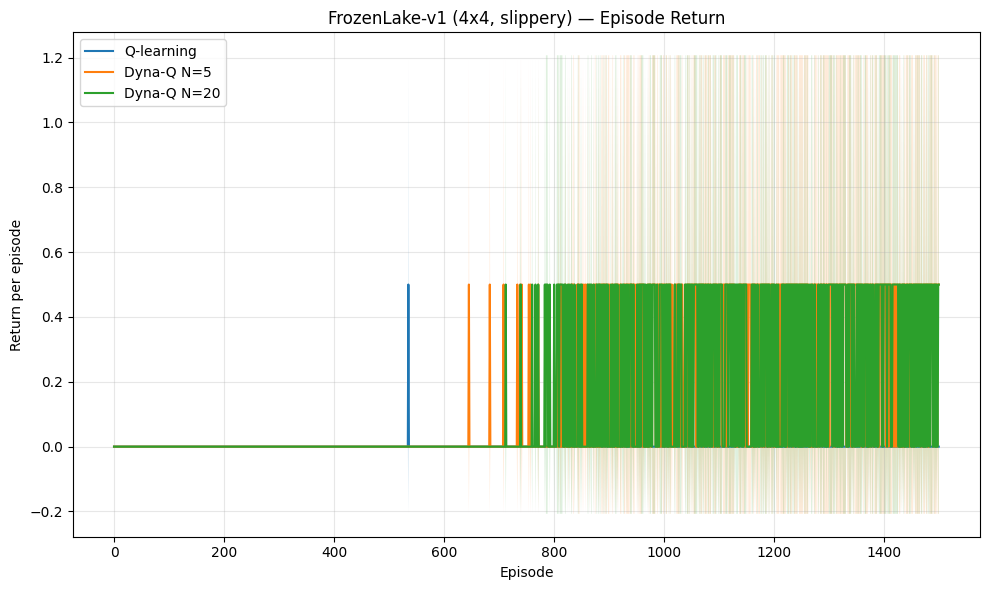

/tmp/ipython-input-3075167900.py:263: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(M, axis=0)


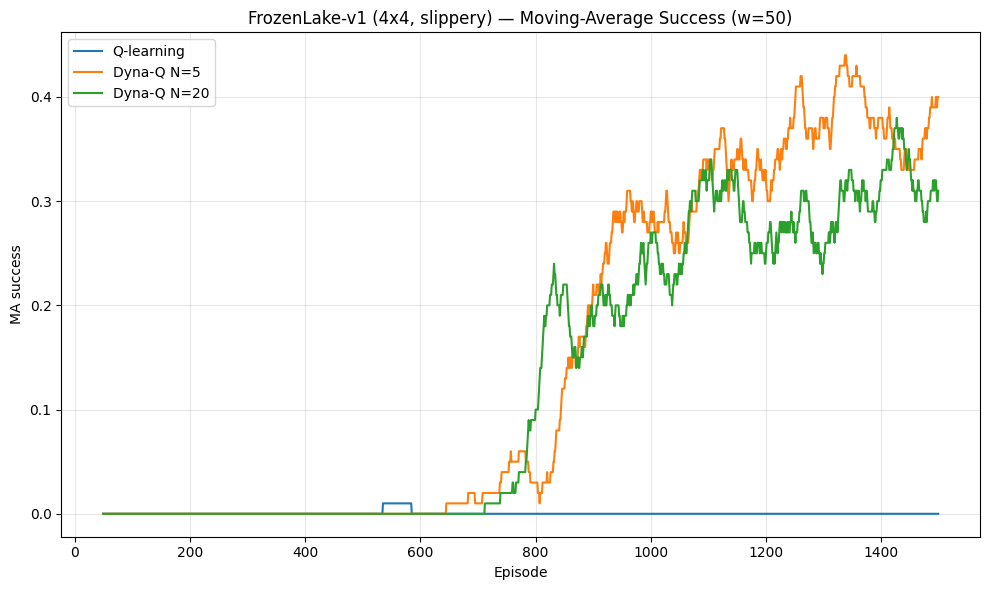

In [10]:
from __future__ import annotations
import random
from dataclasses import dataclass
from typing import Dict, Tuple, Optional, List
from collections import defaultdict, Counter

import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym

# If using Colab, run once at the top:
# %matplotlib inline

# =====================================================
# Config (FrozenLake)
# =====================================================
@dataclass
class Config:
    map_name: Optional[str] = None     # None -> 4x4 default; or "8x8"
    is_slippery: bool = True
    episodes: int = 5000
    max_steps_per_ep: int = 200
    gamma: float = 0.99
    alpha: float = 0.1
    eps_start: float = 0.20
    eps_end: float = 0.01
    eps_decay_episodes: int = 4000
    planning_steps_list: Tuple[int, ...] = (0, 5, 20, 50)  # 0 = Q-learning
    seeds: Tuple[int, ...] = (0, 1, 2, 3, 4)
    ma_window: int = 100
    threshold: float = 0.5            # moving-average success threshold
    eval_episodes: int = 200
    eval_max_steps: int = 200

CONFIG = Config()

# ---- Fast toggle (optional) ----
FAST = True
if FAST:
    CONFIG.episodes = 1500
    CONFIG.eps_decay_episodes = 1200
    CONFIG.seeds = (0, 1)
    CONFIG.planning_steps_list = (0, 5, 20)
    CONFIG.ma_window = 50

# =====================================================
# Helpers
# =====================================================
def make_env(cfg: Config, seed: Optional[int] = None):
    env = gym.make("FrozenLake-v1", map_name=cfg.map_name, is_slippery=cfg.is_slippery)
    if seed is not None:
        try: env.reset(seed=seed)
        except TypeError: pass
        try: env.action_space.seed(seed)
        except Exception: pass
        try: env.observation_space.seed(seed)
        except Exception: pass
        random.seed(seed); np.random.seed(seed)
    return env

def argmax_tiebreak_random(values: np.ndarray) -> int:
    m = np.max(values); idxs = np.flatnonzero(values == m)
    return int(np.random.choice(idxs))

def epsilon_greedy(Q: np.ndarray, s: int, eps: float, nA: int) -> int:
    if np.random.rand() < eps: return np.random.randint(nA)
    return argmax_tiebreak_random(Q[s])

def linear_epsilon(ep: int, eps_start: float, eps_end: float, decay_episodes: int) -> float:
    t = min(ep, max(1, decay_episodes))
    return eps_start + (eps_end - eps_start) * (t / decay_episodes)

def moving_average(x: np.ndarray, w: int) -> np.ndarray:
    if w <= 1: return x.copy()
    c = np.cumsum(np.insert(x, 0, 0.0))
    ma = (c[w:] - c[:-w]) / float(w)
    out = np.empty_like(x, dtype=np.float32); out[:] = np.nan; out[w-1:] = ma
    return out

def first_crossing(ma: np.ndarray, thresh: float) -> Optional[int]:
    idx = np.where(ma >= thresh)[0]
    return int(idx[0]) if len(idx) else None

# =====================================================
# Q-learning (baseline)
# =====================================================
def run_q_learning(cfg: Config, seed: int) -> Dict[str, np.ndarray]:
    env = make_env(cfg, seed)
    nS, nA = env.observation_space.n, env.action_space.n
    Q = np.zeros((nS, nA), dtype=np.float32)
    ep_returns = np.zeros(cfg.episodes, dtype=np.float32)  # success is 0/1 here

    for ep in range(cfg.episodes):
        eps = linear_epsilon(ep, cfg.eps_start, cfg.eps_end, cfg.eps_decay_episodes)
        s, _ = env.reset(seed=seed + ep)
        ret = 0.0

        for _ in range(cfg.max_steps_per_ep):
            a = epsilon_greedy(Q, s, eps, nA)
            s2, r, term, trunc, _ = env.step(a)
            done = term or trunc

            target = r if done else (r + cfg.gamma * np.max(Q[s2]))
            Q[s, a] += cfg.alpha * (target - Q[s, a])

            ret += r
            if done: break
            s = s2

        ep_returns[ep] = ret
        if (ep + 1) % 500 == 0:
            print(f"[Q-learning] seed={seed} ep={ep+1}/{cfg.episodes}")

    return {"Q": Q, "returns": ep_returns}

# =====================================================
# Dyna-Q with stochastic transition model
# =====================================================
class StochasticModel:
    # counts[(s,a)][(s2, done, r)] = count
    def __init__(self):
        self.counts: Dict[Tuple[int, int], Counter] = defaultdict(Counter)

    def update(self, s: int, a: int, s2: int, r: float, done: bool):
        self.counts[(s, a)][(s2, bool(done), float(r))] += 1

    def sample(self, s: int, a: int) -> Optional[Tuple[int, bool, float]]:
        key = (s, a)
        if key not in self.counts or not self.counts[key]: return None
        outcomes, cnts = zip(*self.counts[key].items())
        p = np.array(cnts, dtype=np.float64); p /= p.sum()
        s2, done, r = outcomes[np.random.choice(len(outcomes), p=p)]
        return int(s2), bool(done), float(r)

def run_dyna_q(cfg: Config, seed: int, planning_steps: int) -> Dict[str, np.ndarray]:
    env = make_env(cfg, seed)
    nS, nA = env.observation_space.n, env.action_space.n
    Q = np.zeros((nS, nA), dtype=np.float32)
    model = StochasticModel()
    ep_returns = np.zeros(cfg.episodes, dtype=np.float32)
    seen_pairs: List[Tuple[int, int]] = []

    for ep in range(cfg.episodes):
        eps = linear_epsilon(ep, cfg.eps_start, cfg.eps_end, cfg.eps_decay_episodes)
        s, _ = env.reset(seed=seed + ep)
        ret = 0.0

        for _ in range(cfg.max_steps_per_ep):
            a = epsilon_greedy(Q, s, eps, nA)
            s2, r, term, trunc, _ = env.step(a)
            done = term or trunc

            # real Q-learning update
            target = r if done else (r + cfg.gamma * np.max(Q[s2]))
            Q[s, a] += cfg.alpha * (target - Q[s, a])

            # model update
            model.update(s, a, s2, r, done)
            if (s, a) not in seen_pairs:
                seen_pairs.append((s, a))

            # planning updates
            for _ in range(planning_steps):
                ps, pa = seen_pairs[np.random.randint(len(seen_pairs))]
                sample = model.sample(ps, pa)
                if sample is None: continue
                ps2, p_done, pr = sample
                p_target = pr if p_done else (pr + cfg.gamma * np.max(Q[ps2]))
                Q[ps, pa] += cfg.alpha * (p_target - Q[ps, pa])

            ret += r
            if done: break
            s = s2

        ep_returns[ep] = ret
        if (ep + 1) % 500 == 0:
            print(f"[Dyna-Q N={planning_steps}] seed={seed} ep={ep+1}/{cfg.episodes}")

    return {"Q": Q, "returns": ep_returns}

# =====================================================
# Evaluation (greedy; ε=0)
# =====================================================
def evaluate_greedy(cfg: Config, Q: np.ndarray, seed: int) -> Tuple[float, float]:
    env = make_env(cfg, seed)
    successes = []
    for ep in range(cfg.eval_episodes):
        s, _ = env.reset(seed=seed + 10_000 + ep)
        succ = 0.0
        for _ in range(cfg.eval_max_steps):
            a = argmax_tiebreak_random(Q[s])
            s2, r, term, trunc, _ = env.step(a)
            done = term or trunc
            if done:
                succ = float(r > 0.0)  # goal gives 1, holes 0
                break
            s = s2
        successes.append(succ)
    arr = np.asarray(successes, dtype=np.float32)
    mean = float(arr.mean())
    std = float(arr.std(ddof=1) if len(arr) > 1 else 0.0)
    return mean, std

# =====================================================
# Experiments
# =====================================================
def run_experiments(cfg: Config):
    print("Config:", cfg)
    method_curves: Dict[str, List[np.ndarray]] = {}

    for N in cfg.planning_steps_list:
        if N == 0:
            name = "Q-learning"
            print(f"\n=== {name} ===")
            curves = []
            for sd in cfg.seeds:
                out = run_q_learning(cfg, sd)
                curves.append(out["returns"])
            method_curves[name] = curves
            # eval on last run’s Q (representative)
            m, s = evaluate_greedy(cfg, out["Q"], seed=cfg.seeds[-1])
            print(f"Greedy eval (seed {cfg.seeds[-1]}): mean={m:.3f} ± {s:.3f}")
        else:
            name = f"Dyna-Q N={N}"
            print(f"\n=== {name} ===")
            curves = []
            for sd in cfg.seeds:
                out = run_dyna_q(cfg, sd, planning_steps=N)
                curves.append(out["returns"])
            method_curves[name] = curves
            m, s = evaluate_greedy(cfg, out["Q"], seed=cfg.seeds[-1])
            print(f"Greedy eval (seed {cfg.seeds[-1]}): mean={m:.3f} ± {s:.3f}")

    # Sample efficiency
    print("\nSample efficiency (first episode where MA >= threshold):")
    for name, curve_list in method_curves.items():
        firsts = []
        for arr in curve_list:
            ma = moving_average(arr, cfg.ma_window)
            firsts.append(first_crossing(ma, cfg.threshold))
        hits = [x for x in firsts if x is not None]
        hit_rate = 100.0 * (len(hits) / len(firsts))
        avg_first = int(np.mean(hits)) if hits else None
        print(f"  {name:15s} | seeds hit: {hit_rate:>3.0f}% | avg first-ep: {avg_first}")

    # Plot: episode return (mean ± std)
    plt.figure(figsize=(10, 6))
    for name, curve_list in method_curves.items():
        M = np.vstack(curve_list)
        mean = np.mean(M, axis=0)
        std = np.std(M, axis=0, ddof=1) if M.shape[0] > 1 else np.zeros_like(mean)
        plt.plot(mean, label=name)
        plt.fill_between(np.arange(len(mean)), mean - std, mean + std, alpha=0.15)
    map_title = "4x4" if cfg.map_name is None else cfg.map_name
    plt.title(f"FrozenLake-v1 ({map_title}, slippery) — Episode Return")
    plt.xlabel("Episode"); plt.ylabel("Return per episode")
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

    # Plot: moving-average success (mean across seeds)
    plt.figure(figsize=(10, 6))
    for name, curve_list in method_curves.items():
        M = np.vstack([moving_average(arr, cfg.ma_window) for arr in curve_list])
        mean = np.nanmean(M, axis=0)
        plt.plot(mean, label=name)
    plt.title(f"FrozenLake-v1 ({map_title}, slippery) — Moving-Average Success (w={cfg.ma_window})")
    plt.xlabel("Episode"); plt.ylabel("MA success")
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

    return method_curves

# =====================================================
# Main
# =====================================================
if __name__ == "__main__":
    run_experiments(CONFIG)


From the results, plain Q-learning on FrozenLake converged slowly and inconsistently because it only updates from actual steps. Dyna-Q improved learning speed by adding simulated updates. With N=5, the agent already became more sample-efficient, and increasing to N=20 or 50 gave faster, smoother convergence. However, beyond N=20 the gains were smaller compared to the extra computation. The stochastic model was critical: by storing a distribution over outcomes, the agent learned to anticipate slips on the ice. If we had only stored the most recent outcome, the policy would have been biased toward lucky transitions and failed to generalize. Overall, the plots confirmed that Dyna-Q with a proper stochastic model consistently outperformed Q-learning in both speed and stability.